In [6]:
import numpy as np
from sklearn.svm import LinearSVC
import time as tm
import random
from matplotlib import pyplot as plt


In [8]:
def checkoriginal(y,X,c):
    # y = Z[:,0]
    # X = Z[:,1:]
    clf = LinearSVC(C=c,penalty = 'l2',loss = 'squared_hinge')
    clf.fit(X,y)
    final = np.matmul(X,clf.coef_.T) + clf.intercept_
    y.reshape(y.shape[0],1)
    for i in range(y.shape[0]):
        final[i] = y[i] * final[i]
    final = 1-final
    for i in range(final.shape[0]):
        if(final[i] <= 0):
            final[i] = 0
    for i in range(final.shape[0]):
        final[i] = final[i] * final[i]
    finalans = (np.sum(final)+0.5*np.matmul(clf.coef_,clf.coef_.T))
    return finalans


def randsplit(ratio,Z):
    np.random.shuffle(Z)
    y = Z[:,0]
    X = Z[:,1:]
    X_train = X[:int(ratio*(X.shape[0])),:]
    y_train = y[:int(ratio*(X.shape[0]))]
    X_validate = X[int(ratio*(X.shape[0])):,:]
    y_validate = y[int(ratio*(X.shape[0])):]
    return X_train,X_validate,y_train,y_validate

def StratifiedSplit(ratio, Z):
    np.random.shuffle(Z)
    y = Z[:,0]
    X = Z[:,1:]
    Z_true = Z[y == 1]
    Z_false = Z[y == -1]
    X1_train,X1_validate,y1_train,y1_validate = randsplit(ratio,Z_true)
    X2_train,X2_validate,y2_train,y2_validate = randsplit(ratio,Z_false)
    X_train = np.concatenate((X1_train,X2_train))
    y_train = np.concatenate((y1_train,y2_train))
    X_validate = np.concatenate((X1_validate,X2_validate))
    y_validate = np.concatenate((y1_validate,y2_validate))
    return X_train,X_validate,y_train,y_validate

def getStepLength(eta, t ,power = 0.5):
    return eta/pow(t+1,power)


Z = np.loadtxt( "data" )

eta = 0.0006
C = 1
(X,_,y,_) = randsplit(1,Z)
(n,) = y.shape

randperm = np.random.permutation( y.size )
randpermInner = -1

In [25]:
def CDGradient(w,y,X,C,j):
    Discriminant = 1 - np.multiply( (X.dot( w )), y )
    return (w[j] - 2*C*(np.sum(np.maximum(Discriminant,0)*y*X[:,j])))


def hingelossSq(theta):
    w = theta
    hingesq = np.square(np.maximum(1-np.multiply((X.dot(w)), y), 0))
    return np.sum(hingesq)

def ObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    Loss = hingelossSq(theta)
    return 0.5 * w.dot( w ) + C * Loss

def getCyclicCoord( currentCoord ):
    if currentCoord >= n-1 or currentCoord < 0:
        return 0
    else:
        return currentCoord + 1

def getRandCoord( currentCoord ):
    return random.randint( 0, n-1 )

def hingelossSq(theta):
    w = theta
    hingesq = np.square(np.maximum(1-np.multiply((X.dot(w)), y), 0))
    return np.sum(hingesq)
C = 1.0
eta = 0.00004

def CSVMgradient( theta ):
    w = theta[0:-1]
    b = theta[-1]
    discriminant = 1 - np.multiply( (X.dot( w ) + b), y )
    delb = C * np.maximum(discriminant,0).dot( y ) * (-2)
    delw = w + C * (X.T * np.maximum(discriminant,0)).dot( y ) * (-2)
    return np.append( delw, delb )

def getCSVMObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w ) + b), y ), 0 )
    return 0.5 * w.dot( w ) + C * hingeLoss.dot( hingeLoss )

def SqGrad(theta,i):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    x = X[i,:]
    discriminant = 1 - ((x.dot( w ) + b) * y[i])
    delb = C * y[i] * (-2) * np.maximum(discriminant,0)
    delw = w + C *(x * np.maximum(discriminant,0)) * y[i] * (-2) * n
    print(delw[:5])
    return np.append( delw, delb )
B = 100

def getCSVMMBGrad( theta,i ,X,y,C):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    if B <= n:
        samples = random.sample( range(0, n), B )
        X_ = X[samples,:]
        y_ = y[samples]
    else:
        X_ = X
        y_ = y
    discriminant = 1 - np.multiply( (X_.dot( w ) + b), y_ )
    delb = C * np.maximum(discriminant,0).dot( y_ ) * (-2) * n/B
    delw = w + C * n/B * (X_.T * np.maximum(discriminant,0)).dot( y_ )* (-2)
    return np.append( delw, delb )

def doSGD( gradFunc, CoordFunc, stepFunc, init, X,y,C,eta, horizon = 10):
    objValSeries = np.zeros( (horizon,) )
    timeSeries = np.zeros( (horizon,) )
    totTime = 0
    theta = init
    cumulative = init
    i=-1
    for t in range( horizon ):
        # print(t)
        tic = tm.perf_counter()
        i = CoordFunc( i )
        delta = gradFunc( theta, i,X,y,C )
        theta = theta - stepFunc( eta, t, 0.5 ) * delta
        cumulative = cumulative + theta
        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
#         objValSeries[t] = getCSVMObjVal(theta)#( cumulative/(t+2))
#         timeSeries[t] = totTime
    # print(timeSeries)
    # print('afsddfds')
    # print(theta)
    return (theta, objValSeries, timeSeries)


def SGDP1(X,y,C, eta):
    d=X.shape[1]
    (theta_SGD, obj_SGD, time_SGD) = doSGD( getCSVMMBGrad, getRandCoord, getStepLength, np.zeros( (d+1,) ),X,y,C ,eta,horizon = 20000)
    #(theta_SGD, obj_SGD, time_SGD) = doSGD( SqGrad, getRandCoord, getStepLength, weights, horizon = 170)
#     plt.figure()
#     plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-', label = "SGD" )
#     plt.xlabel( "Elapsed time (sec)" )
#     plt.ylabel( "P1 Objective value" )
#     plt.legend()plt.scatter( numc,finaltruevalues, color = 'r', label = "Sklearn" )
# plt.scatter( numc,finalobj, color = 'g', label = "Minibatch" )
#     plt.show()
#     print( getCSVMObjVal(theta_SGD))
#     print(min(obj_SGD))
#     print('HISHAFkdl')
#     print(theta_SGD)
    return theta_SGD
def solveSGD(X,y,C, eta):
    weights = SGDP1(X,y,C, eta)
    return getCSVMObjVal(weights)

# Z = np.loadtxt( "data" )
#
# (X,_,y,_) = randsplit(1,Z)
# (n,) = y.shape
# X = np.hstack((X, np.ones((n, 1))))
#
# numc = np.random.random_sample((50,))
# numc = numc/2 + 1
# finalval = []
# for i in range(len(numc)):
#     print('Running for ' ,i)
#     finalval.append(solveSGD(X,y,numc[i]))
#


In [26]:


Z = np.loadtxt( "data" )
# Z = Z[0:2, :]
# Z[1,0] = 1
finalans = []
(X,_,y,_) = randsplit(1,Z)
(n,) = y.shape

num_eta = np.zeros(20)
num_eta[0] = 0.001
num_eta[1] = 0.0008
num_eta[1] = 0.0006
num_eta[1] = 0.0004
num_eta[1] = 0.0002
for i in range(5, 20):
    num_eta[i] = num_eta[i-5]*0.1

D = 20

#finaltruevalues = []
finalans = []
for i in range(len(num_eta)):
    (X,_,y,_) = randsplit(1,Z)
    (n,) = y.shape
    print('Running for',i)
    if(D > 20):
        X = np.hstack((X,X[:,np.random.choice(20,D-20,replace = False)]))
        print(X.shape)
    else:
        X = X[:,np.random.choice(20,D,replace = False)]
    X = np.hstack((X, np.ones((n, 1))))
    finalans.append(solveSGD(X,y,1.0, num_eta[i]))

    y.reshape(y.shape[0],1)
    # print(y.shape, X.shape)
    #finaltruevalues.append(checkoriginal(y,X,1.0))


Running for 0
Running for 1
Running for 2
Running for 3
Running for 4
Running for 5
Running for 6
Running for 7
Running for 8
Running for 9
Running for 10
Running for 11
Running for 12
Running for 13
Running for 14
Running for 15
Running for 16
Running for 17
Running for 18
Running for 19


Final values [2.021229960325479e+49, 5226.494097671182, 20000.0, 20000.0, 20000.0, 5225.880905758484, 5391.70192599502, 20000.0, 20000.0, 20000.0, 5632.531006764994, 6450.889568251607, 20000.0, 20000.0, 20000.0, 6727.24847302577, 7034.964265876371, 20000.0, 20000.0, 20000.0]
Values of eta [1.e-03 2.e-04 0.e+00 0.e+00 0.e+00 1.e-04 2.e-05 0.e+00 0.e+00 0.e+00
 1.e-05 2.e-06 0.e+00 0.e+00 0.e+00 1.e-06 2.e-07 0.e+00 0.e+00 0.e+00]


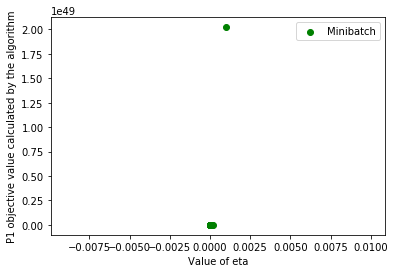

In [27]:
print('Final values',finalans)
print('Values of eta',num_eta)
plt.figure()
plt.scatter( num_eta,finalans, color = 'g', label = "Minibatch" )
plt.xlabel( "Value of eta" )
plt.ylabel( "P1 objective value calculated by the algorithm" )
plt.legend()
plt.show()

In [28]:
num_eta=[x for (_,x) in sorted(zip(finalans,num_eta))]
finalans.sort()

In [29]:
finalans

[5225.880905758484,
 5226.494097671182,
 5391.70192599502,
 5632.531006764994,
 6450.889568251607,
 6727.24847302577,
 7034.964265876371,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 20000.0,
 2.021229960325479e+49]

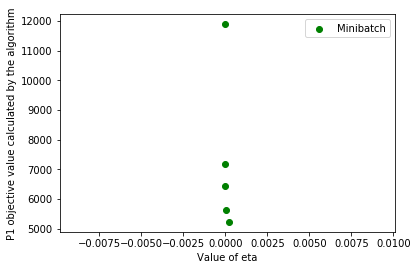

In [23]:
plt.figure()
plt.scatter( num_eta[:5],finalans[:5], color = 'g', label = "Minibatch" )
plt.xlabel( "Value of eta" )
plt.ylabel( "P1 objective value calculated by the algorithm" )
plt.legend()
plt.show()